<a href="https://colab.research.google.com/github/iceman67/-Python/blob/master/kobis_boxoffices_ASOS_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KOBIS 박스오피스 openAPI 사용하기 
* 일별 박스오피스 자료 요청 
* 요청자료를 그룹핑하여 관람객의 변화를 분석함
1. 일자별로 영화관람인을 집계함 
2. 요일별로 영화관람인원을 집계함  
* 토요일에 가장 많은 영화관람이 이루어짐


ASOS  자료  OpenAPI 사용하기
* 범위를 지정하여 자료 요청
* 응답 자료에서 필요한 기상항목을 추출함
1. 기상항목에서 날씨상태를 표현하는 일부를 얻음 (기온, 기압, 풍량)
2. 기상항목에서 필요한 신규자료를 생성함 (날씨 상태: 기압이 1000이상은 좋은날씨로 정의)


닐씨 좋은날 영화관람은 많은가 
* 2018년 자료를 대상으로  KOBIS 박스오피스를 자료를 구성함 (일별로 그룹핑)
* 2018년 자료를 대상으로  ASOS 자료를 구성함(기압, 날씨상태 활용)
* 구성 KOBIS 박스오피스와 ASOS 자료를 결합하여 새로운 자료 항목을 생성함 
* 날씨 상태로 결합된 자료를 그룹핑함 

---

(JSON 요청)

http://kobis.or.kr/kobisopenapi/homepg/apiservice/searchServiceInfo.do

In [2]:
key='01f13234167ec2fd37e0de81f8308b1f'

In [3]:
import json
import requests
import pandas as pd

In [4]:
def getBoxOffice(mDate): 
    mURL = 'http://www.kobis.or.kr/kobisopenapi/webservice/rest/boxoffice/searchDailyBoxOfficeList.json?key=dac1451451ff54f43e1f0f59d3356f86&targetDt='+ str(mDate)
    res = requests.get(mURL)
    text = res.text
    movieData = json.loads(text)
    movieLen = len(movieData['boxOfficeResult']['dailyBoxOfficeList'])
    movieDF = pd.DataFrame()
    #movieDF = movieDF.append(  {"tm":"", "title":"", "cnt":"", "salesShare": "" }, ignore_index=True, sort=False )
    for i in range(movieLen):
        movieDF.loc[i,"tm"] = str(mDate)
        movieDF.loc[i,"tm"] = pd.to_datetime(movieDF.loc[i,"tm"], infer_datetime_format=True)
        movieDF.loc[i,"title"]= movieData['boxOfficeResult']['dailyBoxOfficeList'][i]['movieNm']
        movieDF.loc[i, "cnt"] = movieData['boxOfficeResult']['dailyBoxOfficeList'][i]['salesAmt']
        movieDF.loc[i, "salesShare"] = float(movieData['boxOfficeResult']['dailyBoxOfficeList'][i]['salesShare'])
    return movieDF
    #print(movieDF.head())
    

In [5]:
# 기준일을 2018년 1월으로 지정한 경우임 
base= 20180100
for i in range(1,31):
    movieDF = getBoxOffice(base+i)
    movieDF.to_csv('movie'+str(base+i)+'.csv', encoding='utf-8-sig', index=False,header=False)

In [6]:
# 기준일을 2018년 2월으로 지정한 경우임 
base= 20180200
for i in range(1,29):
    movieDF = getBoxOffice(base+i)
    movieDF.to_csv('movie'+str(base+i)+'.csv', encoding='utf-8-sig', index=False,header=False)

In [7]:
# 기준일을 2018년 3월으로 지정한 경우임 
base= 20181200
for i in range(1,32):
    movieDF = getBoxOffice(base+i)
    movieDF.to_csv('movie'+str(base+i)+'.csv', encoding='utf-8-sig', index=False,header=False)

 KOBIS 자료수집하여 CSV 파일에 저장
 * 수집은 1월 부터 12월로 지정함 
 * 월별 날짜는 다를 수 있으므로 조정이 필요함

In [8]:
# 기준일을 2018년 1월-12월로 지정한 경우임 
# 
for m in range (1,13):
    base= 20180000 + (m * 100)
    if m in [1, 3, 5, 7,8, 10, 12]:
        last = 32
    elif m in [2]:
        last = 29
    else:
        last = 31
    for i in range(1,last):
        movieDF = getBoxOffice(base+i)
        movieDF.to_csv('movie'+str(base+i)+'.csv', encoding='utf-8-sig', index=False,header=False)



KOBIS  자료를 통합 CSV 를 생성하고 분석을 위해 통합데이터프레임을 생성함
* 생성자료는  movie2018.csv 로 저장
* 통합데이터프레임은  total_movie 에 유지함 

In [9]:
import glob

total_movie=pd.DataFrame()
for infile in glob.glob("*.csv"):
    data = pd.read_csv(infile,names=['tm', 'title', 'cnt', 'salesShare', 'salesChange'],
                                     parse_dates=['tm'])
    total_movie=total_movie.append(data,ignore_index=True)

In [10]:
total_movie.head()
base = 2018
total_movie.to_csv('movie'+str(base)+'.csv', encoding='utf-8-sig', index=False, header=None)

In [11]:
total_movie.head()

,tm,title,cnt,salesShare,salesChange
0,2018-01-23,그것만이 내 세상,787874300,25.8,NaN
1,2018-01-23,메이즈 러너: 데스 큐어,721009000,23.6,NaN
2,2018-01-23,코코,527130900,17.2,NaN
3,2018-01-23,신과함께-죄와 벌,367788800,12.0,NaN
4,2018-01-23,1987,371003000,12.1,NaN


날짜에서 요일정보를 얻어  새로운 컬럼  weekday에 유지함

In [12]:
total_movie['weekday'] = total_movie['tm'].dt.dayofweek

사용하지않는 컬럼 salesChange를 데이터프레임에서 제외함

In [13]:
total_movie.head()
total_movie.drop('salesChange',axis=1, inplace=True)

일별로 자료를 그룹핑함 
* 데이터프레임을 날짜로 그룹핑함

In [14]:
grouped = total_movie.groupby(total_movie['tm'], as_index=False).sum()

In [15]:
grouped

,tm,cnt,salesShare,weekday
0,2018-01-01,14449197900,99.0,0
1,2018-01-02,4884883600,98.5,10
2,2018-01-03,4822173800,97.9,20
3,2018-01-04,4615108000,97.6,30
4,2018-01-05,6088851197,98.4,40
...,...,...,...,...
360,2018-12-27,3629453100,94.5,30
361,2018-12-28,4856998437,95.5,40
362,2018-12-29,9287883046,96.7,50
363,2018-12-30,9477942200,97.5,60


In [16]:
movie_day_group = grouped[['tm', 'cnt']]

요일별 자료그룹핑
* 월요일 = 0, 일요일 = 6 인 요일

토요일이 다른 요일에 비해 영화관람이 많은 것을 확인할 수 있음



In [17]:
grouped = total_movie.groupby(total_movie['weekday'], as_index=False).sum()

In [18]:
grouped

,weekday,cnt,salesShare
0,0,164658368950,5065.2
1,1,160354620028,4881.0
2,2,228468167550,5001.3
3,3,171037390800,4941.0
4,4,222762161048,5005.7
5,5,426581414667,5044.9
6,6,386125019300,5044.5


요일에 따른  cnt를 시각화하여 결과를 점검함

In [19]:
grouped.cnt

0    164658368950
1    160354620028
2    228468167550
3    171037390800
4    222762161048
5    426581414667
6    386125019300
Name: cnt, dtype: int64

### (단계 1)저장된 movie2018.csv를 사용하여 데이터 분석을 진행함 

In [20]:
from google.colab import drive

In [21]:
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
movie_file_path = "/content/drive/MyDrive/DA/movie2018.csv"
asos_file_path="/content/drive/MyDrive/DA/ASOS_108.csv"

In [23]:
import pandas as pd

#df_movie = pd.read_csv('movie2018.csv', names = ['tm', 'title', 'cnt', 'salesShare', 'salesChange'], parse_dates=['tm'])
df_movie = pd.read_csv(movie_file_path, names = ['tm', 'title', 'cnt', 'salesShare', 'salesChange'], parse_dates=['tm'])


In [24]:
df_movie.head()

,tm,title,cnt,salesShare,salesChange
0,2018-05-11,어벤져스: 인피니티 워,1382669274,58.2,NaN
1,2018-05-11,레슬러,593749474,25.0,NaN
2,2018-05-11,챔피언,202266826,8.5,NaN
3,2018-05-11,루비 스팍스,31416000,1.3,NaN
4,2018-05-11,당갈,21798400,0.9,NaN


In [25]:
df_movie.drop('salesChange',axis=1, inplace=True)
df_movie.drop('salesShare',axis=1, inplace=True)

In [26]:
df_movie.head()

,tm,title,cnt
0,2018-05-11,어벤져스: 인피니티 워,1382669274
1,2018-05-11,레슬러,593749474
2,2018-05-11,챔피언,202266826
3,2018-05-11,루비 스팍스,31416000
4,2018-05-11,당갈,21798400


### (2단계) 날짜를 기준으로 자료를 그룹핑하여 영화관람을 누적함

In [66]:
grouped = df_movie.groupby(df_movie['tm'], as_index=False).sum()

In [67]:
grouped

,tm,cnt
0,2018-01-01,14449197900
1,2018-01-02,4884883600
2,2018-01-03,4822173800
3,2018-01-04,4615108000
4,2018-01-05,6088851197
...,...,...
360,2018-12-27,3629453100
361,2018-12-28,4856998437
362,2018-12-29,9287883046
363,2018-12-30,9477942200


요일별로 자료를 정리함

In [68]:
grouped['weekday'] = grouped['tm'].dt.dayofweek

In [74]:
grouped['month'] = grouped['tm'].dt.month

In [75]:
grouped.head()

,tm,cnt,weekday,month
0,2018-01-01,14449197900,0,1
1,2018-01-02,4884883600,1,1
2,2018-01-03,4822173800,2,1
3,2018-01-04,4615108000,3,1
4,2018-01-05,6088851197,4,1


Text(0.5, 1.0, 'Movie watcher')

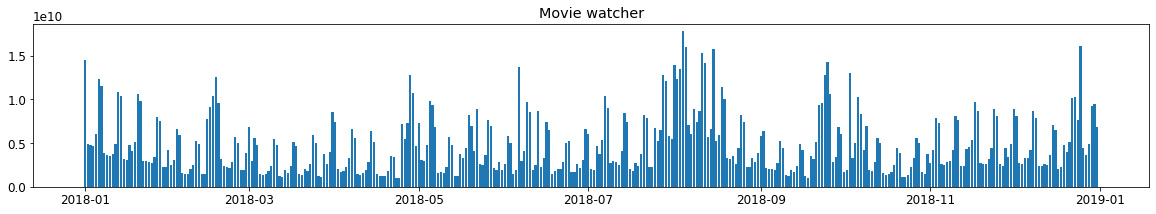

In [70]:
import matplotlib.pyplot as plt

plt.bar(grouped['tm'], grouped['cnt'])
plt.title("Movie watcher")

In [71]:
weekday_grouped = grouped.groupby(grouped['weekday'], as_index=False).sum()

In [33]:
weekday_grouped

,weekday,cnt
0,0,164658368950
1,1,160354620028
2,2,228468167550
3,3,171037390800
4,4,222762161048
5,5,426581414667
6,6,386125019300


요일별 그룹자료을 시각화하여 분석결과를 확인함
* 월요일 = 0, 일요일 = 6 인 요일

<BarContainer object of 7 artists>

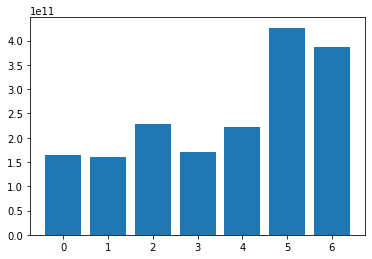

In [34]:
import matplotlib.pyplot as plt

plt.bar(weekday_grouped['weekday'], weekday_grouped['cnt'])

월별 영화관람객을 분석함

In [76]:
month_grouped = grouped.groupby(grouped['month'], as_index=False).sum()

In [ ]:
month_grouped

<BarContainer object of 12 artists>

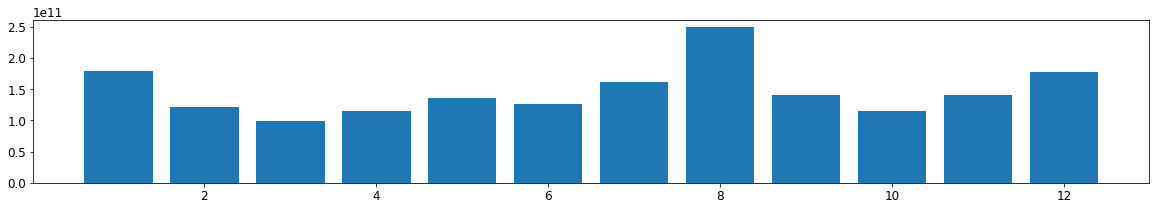

In [78]:
import matplotlib.pyplot as plt

plt.bar(month_grouped['month'], month_grouped['cnt'])

### (3단계)ASOS 데이터 수집 및 전처리

In [35]:
#df_asos = pd.read_csv('ASOS_108.csv',parse_dates=['tm'])
df_asos = pd.read_csv(asos_file_path,parse_dates=['tm'])


In [79]:
df_asos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   stnId   365 non-null    int64         
 1   tm      365 non-null    datetime64[ns]
 2   avgTa   365 non-null    float64       
 3   avgPa   365 non-null    float64       
 4   maxWS   365 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 14.4 KB


In [80]:
merge_df = pd.merge(df_asos,grouped, how='outer',on='tm')

In [81]:
merge_df.head()

,stnId,tm,avgTa,avgPa,maxWS,cnt,weekday,month
0,108,2018-01-01,-1.3,1016.8,3.8,14449197900,0,1
1,108,2018-01-02,-1.8,1018.1,4.9,4884883600,1,1
2,108,2018-01-03,-4.7,1019.9,3.5,4822173800,2,1
3,108,2018-01-04,-4.7,1016.5,3.5,4615108000,3,1
4,108,2018-01-05,-3.0,1010.3,3.6,6088851197,4,1


새로운 컬럼 w_cond 추가
* 날씨조건

In [82]:
import numpy as np

merge_df['w_cond'] = np.where(merge_df['avgPa'] > 1000, True, False)
#merge_df['w_cond'] = np.where(  (merge_df['avgTa'] > 20) & (merge_df['avgTa'] < 26), True, False)


In [83]:
merge_df.head()

,stnId,tm,avgTa,avgPa,maxWS,cnt,weekday,month,w_cond
0,108,2018-01-01,-1.3,1016.8,3.8,14449197900,0,1,True
1,108,2018-01-02,-1.8,1018.1,4.9,4884883600,1,1,True
2,108,2018-01-03,-4.7,1019.9,3.5,4822173800,2,1,True
3,108,2018-01-04,-4.7,1016.5,3.5,4615108000,3,1,True
4,108,2018-01-05,-3.0,1010.3,3.6,6088851197,4,1,True


w_cond를 기준으로 자료를 그룹핑 

In [84]:
wgroup = merge_df.groupby(merge_df['w_cond'], as_index=False).sum()

In [85]:
wgroup

,w_cond,stnId,avgTa,avgPa,maxWS,cnt,weekday,month
0,False,9612,2188.4,88669.0,376.7,501367987942,270,613
1,True,29808,2557.5,278716.2,1070.8,1258619154401,822,1769


<BarContainer object of 2 artists>

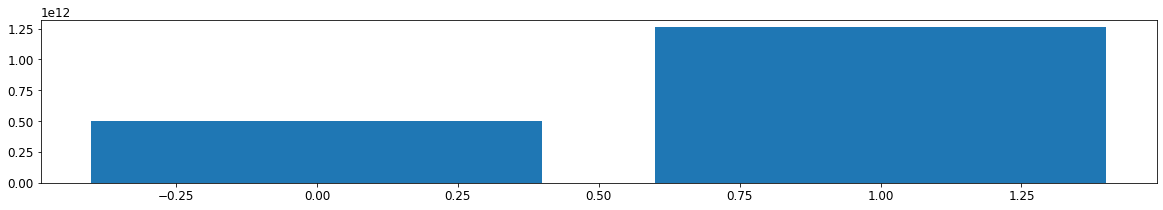

In [87]:
import matplotlib.pyplot as plt

plt.bar ( wgroup['w_cond'], wgroup['cnt'])

In [91]:
#wgroup["w_cond_int"] = wgroup["w_cond"].astype(int)
                                             
wgroup['w_cond_str'] = wgroup['w_cond'].map({True: 'Good weather', False: 'Bad weather'})  #

In [90]:
wgroup

,w_cond,stnId,avgTa,avgPa,maxWS,cnt,weekday,month,w_cond_int
0,False,9612,2188.4,88669.0,376.7,501367987942,270,613,0
1,True,29808,2557.5,278716.2,1070.8,1258619154401,822,1769,1


<BarContainer object of 2 artists>

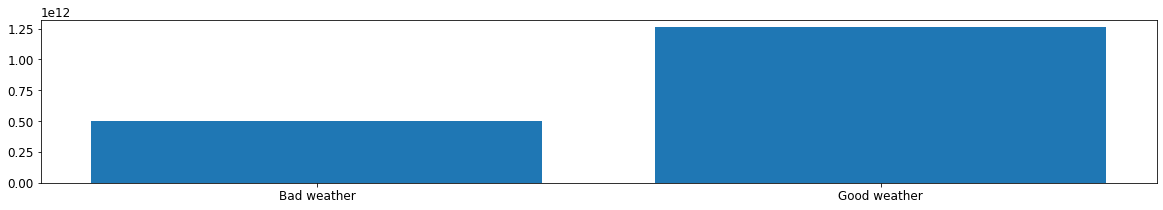

In [92]:
import matplotlib.pyplot as plt

plt.bar ( wgroup['w_cond_str'], wgroup['cnt'])

### (데이터 전처리 실습) 2018년 8월 요일별 영화관객 분석

In [45]:
# 기준일을 2018년 8월으로 지정한 경우임 
base= 20180800
for i in range(1,32):
    movieDF = getBoxOffice(base+i)
    movieDF.to_csv('movie'+str(base+i)+'.csv', encoding='utf-8-sig', index=False,header=False)

In [46]:
import glob

total_movie=pd.DataFrame()
for infile in glob.glob("*.csv"):
    data = pd.read_csv(infile,names=['tm', 'title', 'cnt', 'salesShare', 'salesChange'],
                                     parse_dates=['tm'])
    total_movie=total_movie.append(data,ignore_index=True)

In [47]:
total_movie.head()
base = 2018
total_movie.to_csv('movie'+str(base)+'.csv', encoding='utf-8-sig', index=False, header=None)

In [48]:
total_movie.head()

,tm,title,cnt,salesShare,salesChange
0,2018-01-23,그것만이 내 세상,787874300,25.8,NaN
1,2018-01-23,메이즈 러너: 데스 큐어,721009000,23.6,NaN
2,2018-01-23,코코,527130900,17.2,NaN
3,2018-01-23,신과함께-죄와 벌,367788800,12.0,NaN
4,2018-01-23,1987,371003000,12.1,NaN


In [49]:
total_movie['weekday'] = total_movie['tm'].dt.dayofweek

In [50]:
total_movie.head()
total_movie.drop('salesChange',axis=1, inplace=True)

요일별 자료그룹핑
* 월요일 = 0, 일요일 = 6 인 요일



In [51]:
grouped = total_movie.groupby(total_movie['weekday'], as_index=False).sum()

In [52]:
grouped

,weekday,cnt,salesShare
0,0,329316737900,10130.4
1,1,320709240056,9762.0
2,2,456936335100,10002.6
3,3,342074781600,9882.0
4,4,445524322096,10011.4
5,5,853162829334,10089.8
6,6,772250038600,10089.0
